# Bacterial strain mutant analysis
Notebook used for playing around with the basics of Python during the coding session of the Introduction to Programming course.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py as hf

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

### Study the training HDF5 file

In [2]:
f = hf.File("data_mutants/MutantsDataset_train.hdf5","r")

print(f.keys())
print(f['Genotypes'])
print(f['Phenotypes'])
print(f['Genotypes'].keys())
print(f['Genotypes/GT'])
print(f['Genotypes/Mutants'])

<KeysViewHDF5 ['Genotypes', 'Phenotypes']>
<HDF5 group "/Genotypes" (2 members)>
<HDF5 dataset "Phenotypes": shape (1000,), type "<f8">
<KeysViewHDF5 ['GT', 'Mutants']>
<HDF5 dataset "GT": shape (1,), type "|O">
<HDF5 dataset "Mutants": shape (1000,), type "|O">


Read the ground truth and find out more about it:

In [3]:
# Read ground truth (GT), cast to string and take first element:
gt = f['Genotypes/GT'][:].astype(str)[0]

# Information about the GT:
print(f"GT sequences: {gt}")
print(f"# of bases: {len(gt)}")
print(f"GT contains {gt.count('T')} Ts and {gt.count('U')} Us -> DNA")

GT sequences: AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGC
# of bases: 70
GT contains 21 Ts and 0 Us -> DNA


Read the mutant sequences:

In [4]:
# Read mutant (MT) array:
mt = f['Genotypes/Mutants'][:].astype(str)
mt = np.array([list(x) for x in mt]) # convert strings to characters

Read the phenotype for later:

In [5]:
# Read in the phenotype (PT):
pt = f['Phenotypes'][:]
f.close() # close the file, as everything is read now

### Find common SNPs
Locate positions where mutations (= deviations from the GT) are present:

In [6]:
# Find SNP positions (not frequency):
snp_pos = np.zeros(len(gt))

for i in range(len(gt)):
    snp_pos[i] = (mt[:,i]!=gt[i]).any()

print(f"# of positions with mutations: {int(snp_pos.sum())}")

# of positions with mutations: 40


Find frequencies of mutations (irrespective of type of mutation) and significantly mutated positions:

In [7]:
# Find SNP frequencies:
snp_freq = np.zeros(len(gt))

for i in range(len(gt)):
    snp_freq[i] = (mt[:,i]!=gt[i]).sum()/len(mt)

# Print position and frequency as a data frame:
snp_df = pd.DataFrame({"SNP_pos": snp_pos, "SNP_freq": snp_freq})
snp_df["SNP_sig"] = snp_df["SNP_freq"] > 0.05 # also evaluate significance
print(f"# of significantly mutated positions: {snp_df['SNP_sig'].sum()}")
snp_df

# of significantly mutated positions: 31


,SNP_pos,SNP_freq,SNP_sig
0,0.0,0.000,False
1,0.0,0.000,False
2,0.0,0.000,False
3,1.0,0.178,True
4,0.0,0.000,False
...,...,...,...
65,0.0,0.000,False
66,1.0,0.047,False
67,0.0,0.000,False
68,1.0,0.151,True


Plot the mutation frequency along the genome:

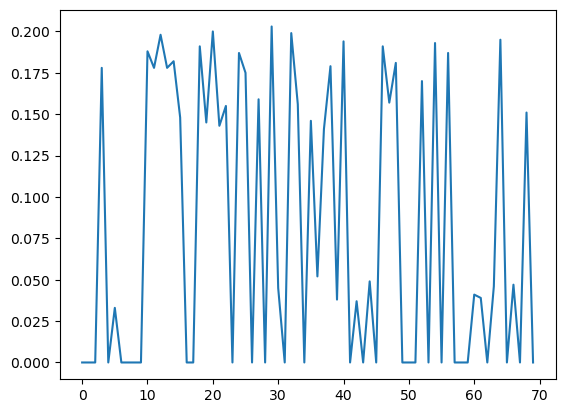

In [8]:
plt.plot(range(len(snp_df)), snp_df["SNP_freq"])
plt.show()

Recode the mutants (0 = no mutation; 1 = mutated):

In [9]:
mt_recode = np.zeros(mt.shape)
for i in range(len(gt)):
    mt_recode[:,i] = (mt[:,i]!=gt[i]).astype(int)

Subset the mutants to only include significant mutations:

In [10]:
snp_sig = mt_recode[:,snp_freq > 0.05].astype(int)
print(snp_sig.shape) # every column with non-significant mutations removed

(1000, 31)


Perform a PCA and plot first two PCs:

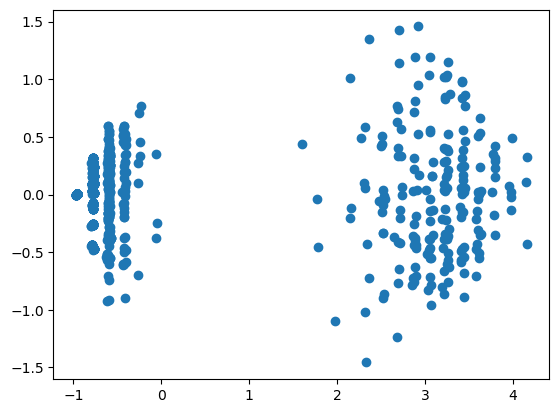

In [11]:
X = PCA(n_components=2).fit_transform(snp_sig)
plt.scatter(X[:,0], X[:,1])
plt.show()

Save the array as a TSV:

In [12]:
export = pd.DataFrame(snp_sig)
export.to_csv("data_output/sig_snps.csv", sep="\t", index=False, header=False)

### Select significant SNPs
Plot the first SNP against the phenotype:

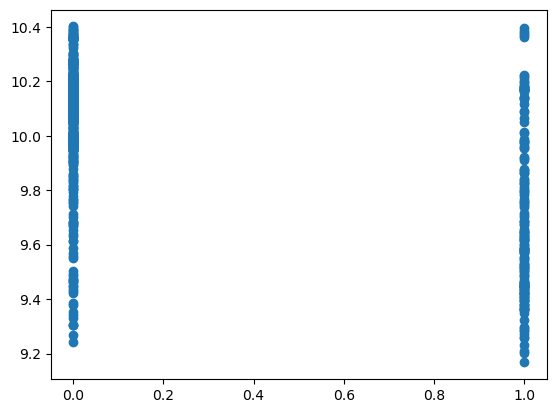

In [13]:
# Plot the first phenotype:
plt.scatter(snp_sig[:,0], pt)
plt.show()

Perform a linear regression on all SNPs:

In [14]:
p1 = 1
p2 = 2

p_vals = np.zeros(snp_sig.shape[1]) # initialize to width of array

for i in range(snp_sig.shape[1]):
    lin = LinearRegression()
    lin.fit(snp_sig[:,i].reshape(-1,1), pt)
    y_pred = lin.predict(snp_sig[:,i].reshape(-1,1))
    rss1 = ((pt - lin.intercept_)**2).mean()
    rss2 = ((pt - y_pred)**2).mean()
    f_stat = ((rss1-rss2)/(p2-p1))/(rss1/(1000-p2))
    p_vals[i] = stats.f.sf(f_stat, 1000-p2, p2-p1)

print("p-values per position:")
print(p_vals) # p-values per position

print("\nSignificant positions (1 = significant):")
print((p_vals < 0.05).astype(int)) # significance per position

p-values per position:
[0.03841277 0.04140169 0.04029666 0.04260204 0.03916018 0.04030252
 0.03367786 0.03593206 0.03438245 0.0532193  0.03325619 0.02954272
 0.03679561 0.03004614 0.03100929 0.03957313 0.03961196 0.03296794
 0.03436267 0.21977653 0.03232671 0.03958824 0.03829508 0.03456351
 0.03231778 0.04339196 0.03756933 0.03172244 0.03453006 0.03590912
 0.03319996]

Significant positions (1 = significant):
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]


Save the result to a TSV:

In [15]:
export = pd.DataFrame(snp_sig[:,p_vals < 0.05])
export.to_csv("data_output/sig_p_vals.csv", index=False, sep="\t")

### Phenotype prediction
Regress significant SNPs against phenotype with a linear regression:

In [16]:
lin_sig = LinearRegression()
lin_sig.fit(snp_sig[:,p_vals < 0.05], pt)

LinearRegression()

Read the test data and repeat procedure used for the training data:

In [17]:
t = hf.File("data_mutants/MutantsDataset_test.hdf5","r")

t_mt = t['Genotypes/Mutants'][:].astype(str)
t_mt = np.array([list(x) for x in t_mt])

t_mt_recode = np.zeros(t_mt.shape)

for i in range(len(gt)):
    t_mt_recode[:,i] = (t_mt[:,i]!=gt[i]).astype(int)

t_snp_sig = t_mt_recode[:,snp_freq > 0.05].astype(int)
print(t_snp_sig.shape) # every column with non-significant mutations removed

t_snp_sig = t_snp_sig[:,p_vals < 0.05]

t_pt = t['Phenotypes'][:]
t.close()

(200, 31)


Test the model by predicting the phenotype:

In [18]:
t_y_pred = lin_sig.predict(t_snp_sig)

r_2 = 1 - ((t_y_pred - t_pt)**2).mean()/(t_pt.var()) # R^2 calculation
r = np.corrcoef(t_y_pred,t_pt)[0,1] # correlation coefficient

print(r, r_2)

0.8896881568768764 0.7909020470721266


As can be observed, the model predicts the phenotype reasonably well!